In [1]:
import pandas as pd
import geopandas
import pypsa
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import interp1d
%matplotlib inline
import cartopy.crs as ccrs

Error loading 'pyutilib.component' entry points: 'The 'nose' distribution was not found and is required by the application'


In [2]:
years = np.arange(2020,2055,5)
sns.set_style("ticks")
figsize=(12,9)
fs = 20
fs_s = 18
mew = 3
ms = 15
lw = 3
tech_colors = pd.read_csv('../color_scheme.csv',index_col=0,squeeze=True)

In [3]:
def rename_techs(label):
    if label[:8] == "central ":
        label = label[8:]
    if label[:6] == "urban ":
        label = label[6:]
    if "retrofitting" in label:
        label = "building retrofitting"
    if "H2" in label:
        label = "hydrogen storage"
    if "CHP" in label:
        label = "CHP"
    if "water tank" in label:
        label = "water tanks"
    if label=="water tanks":
        label = "hot water storage"
    if "gas" in label and label != "gas boiler" and label != "gas cooler":
        label = "gas"
    if "OCGT" in label:
        label = "gas turbine"
    if "CCGT" in label:
        label = "gas turbine"
    if "nuclear" in label:
        label = "nuclear"
    if "lignite" in label:
        label = "lignite"
    if "coal" in label:
        label = "coal"
    if "solar thermal" in label:
        label = "solar thermal"
    if label == "oil Store":
        label = "oil"
    if label == "solar":
        label = "solar PV"
    if "heat pump" in label:
        label = "heat pump"
    if label == "Sabatier":
        label = "methanation"
    if label == "offwind":
        label = "offshore wind"
    if label == "onwind":
        label = "onshore wind"
    if label == "ror":
        label = "hydro"
    if label == "hydro":
        label = "hydro"
    if label == "PHS":
        label = "hydro"
    if "battery" in label:
        label = "battery storage"

    return label

In [4]:
def network_plot(df,bus_size_factor=1.2e8,title='load'):
    fig, ax = plt.subplots(1,1)
    fig.set_size_inches(figsize)

    data = df.stack()
    line_color="m"

    n.buses.loc["NO",["x","y"]] = [7.5,60]

    n.plot(bus_sizes=data/bus_size_factor,
           bus_colors=tech_colors.to_dict(),
           line_colors=dict(Line=line_color, Link=line_color),
           line_widths=10,geomap='50m')

    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

    techs = data.index.levels[1]

    # legend for types of demand
    handles = []
    labels = []
    for t in techs:
        handles.append(plt.Line2D([0], [0], color=tech_colors[t], marker='o', markersize=20, linewidth=0))
        labels.append(t)

    first_legend = plt.legend(handles, labels,fontsize=fs,
               loc="upper left", bbox_to_anchor=(0, 1),
               framealpha=1,borderpad=0.5,labelspacing=0.7,
               handletextpad=0.5, columnspacing=0.5, ncol=1, title=None)
    ax = plt.gca().add_artist(first_legend)

    # handles = []
    # labels = []
    # handles.append(plt.Line2D([0], [0], color='grey', marker='o', markersize=18, linewidth=0))
    # labels.append('100 TWh')
    # second_legend = plt.legend(handles, labels,fontsize=fs,
    #            loc="upper left", bbox_to_anchor=(0.25, 1),
    #            framealpha=1,borderpad=0.5,labelspacing=0.7,
    #            handletextpad=0.5, columnspacing=0.5, ncol=1, title=None)
    # ax = plt.gca().add_artist(second_legend)

    fig.tight_layout()
    fig.savefig('../../figures/spatial_{}.png'.format(title), bbox_inches='tight',dpi=500)

In [14]:
n = pypsa.Network('../results/version-wo_DH_exp/postnetwork-go_opt_2050.nc')
n.buses.drop(n.buses.index[n.buses.index.str.len() != 2],inplace=True)
nodes = (n.buses.index[n.buses.carrier == "AC"])
load = n.loads_t.p_set.sum()

Importing PyPSA from older version of PyPSA than current version 0.14.1.
Please read the release notes at https://pypsa.org/doc/release_notes.html
carefully to prepare your network for import.

INFO:pypsa.io:Imported network postnetwork-go_opt_2050.nc has buses, carriers, generators, global_constraints, links, loads, storage_units, stores


In [15]:
gen_carriers = ['onwind','offwind','solar','ror']
store_carriers = ['coal','oil','lignite','nuclear','gas']
su_carriers = ['hydro']

In [18]:
df = pd.DataFrame(index=nodes,columns=gen_carriers+store_carriers+su_carriers)

In [29]:
for carrier in gen_carriers:
    df[carrier] = n.generators_t.p.sum().filter(like=carrier).rename(lambda x:x[:2]).groupby(level=0).sum()
for carrier in store_carriers:


# carrier = 'hydro'
# try:
#     df.loc[carrier,year] = n.storage_units_t.inflow.sum().filter(like=country).filter(like=carrier).item()
# except ValueError:
#     df.loc[carrier,year] = 0


In [46]:
n.links

,bus0,bus1,capital_cost,efficiency,length,marginal_cost,p_min_pu,p_nom_extendable,p_nom_min,p_nom_opt,type,p_nom,p_nom_max,p_set,p_max_pu,terrain_factor
name,,,,,,,,,,,,,,,,
AT OCGT,AT gas,AT,15844.076916,0.39,0.000000,1.755,0.0,True,11.263698,11.342144,,0.0,inf,0.0,1.0,1.0
BA OCGT,BA gas,BA,15844.076916,0.39,0.000000,1.755,0.0,True,11.200329,11.269135,,0.0,inf,0.0,1.0,1.0
BE OCGT,BE gas,BE,15844.076916,0.39,0.000000,1.755,0.0,True,11.264558,11.336240,,0.0,inf,0.0,1.0,1.0
BG OCGT,BG gas,BG,15844.076916,0.39,0.000000,1.755,0.0,True,10.816112,10.876074,,0.0,inf,0.0,1.0,1.0
CH OCGT,CH gas,CH,15844.076916,0.39,0.000000,1.755,0.0,True,11.184461,11.250143,,0.0,inf,0.0,1.0,1.0
CZ OCGT,CZ gas,CZ,15844.076916,0.39,0.000000,1.755,0.0,True,11.044254,11.087334,,0.0,inf,0.0,1.0,1.0
DE OCGT,DE gas,DE,15844.076916,0.39,0.000000,1.755,0.0,True,2.964220,6.170430,,0.0,inf,0.0,1.0,1.0
DK OCGT,DK gas,DK,15844.076916,0.39,0.000000,1.755,0.0,True,11.242988,11.321337,,0.0,inf,0.0,1.0,1.0
EE OCGT,EE gas,EE,15844.076916,0.39,0.000000,1.755,0.0,True,10.735359,10.801019,,0.0,inf,0.0,1.0,1.0


In [16]:
df = pd.DataFrame(index=nodes)
df['electricity'] = load[nodes]
df['rural heat'] = load[nodes+' heat'].rename(lambda x : x[:2])
df['urban heat'] = load[nodes+' urban heat'].rename(lambda x : x[:2])
df['cooling'] =  load[nodes+' cooling'].rename(lambda x : x[:2])

In [7]:
df = pd.read_csv('../results/version-Base/electricity_production_Base_go.csv',index_col=0,header=[0,1])
index = ['hydro','solar','onwind','offwind']
df = df.reindex(index)
df.rename(index=rename_techs,inplace=True)
df = df.reorder_levels(['year','country'],axis=1)['2050'].T
to_drop = df.columns[df.max(axis=0) < 5]
df.drop(columns=to_drop,inplace=True)

/home/kun/anaconda3/lib/python3.6/site-packages/pypsa/plot.py:178: UserWarning:

Requested projection is different from current axis projection, creating new axis with requested projection.

/home/kun/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: UserWarning:

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 



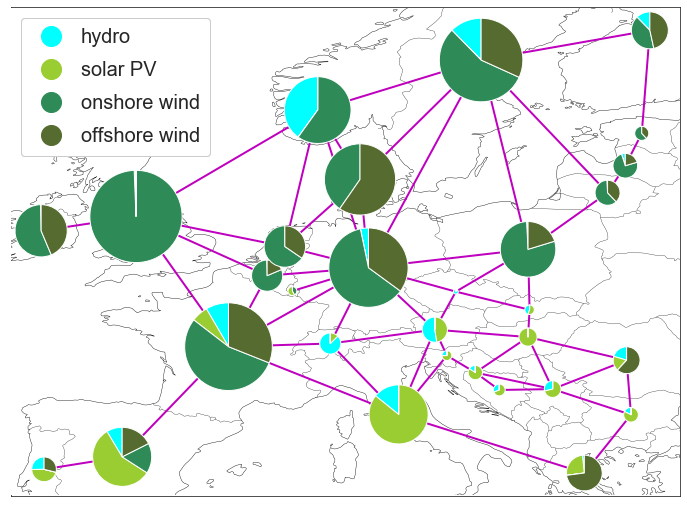

In [8]:
network_plot(df,bus_size_factor=100,title='electricity_production_brownfield')

In [9]:
df = pd.read_csv('../results/version-Base/heat_production_Base_go.csv',index_col=0,header=[0,1])
df.rename(index={'gas boiler':'gas','CHP heat':'gas'},inplace=True)
index = ['gas', 'resistive heater', 'heat pump']
df = df.groupby(level=0).sum().reindex(index=index)
df = df.reorder_levels(['year','country'],axis=1)['2050'].T

/home/kun/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: UserWarning:

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 



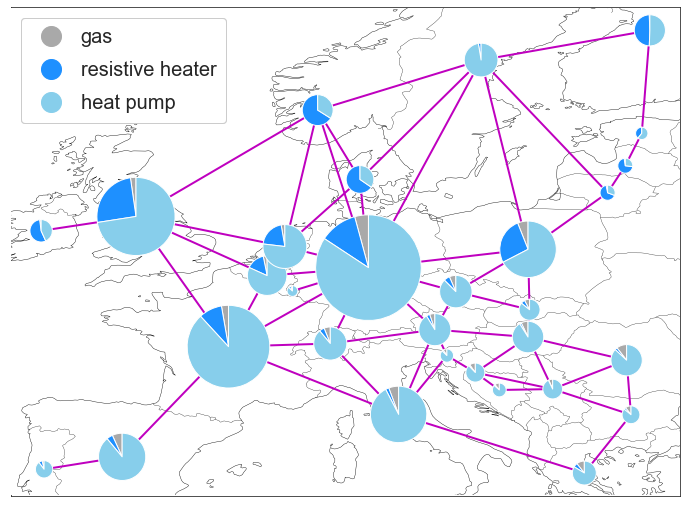

In [10]:
network_plot(df,bus_size_factor=100,title='heat_production_brownfield')

In [11]:
df = pd.read_csv('../results/version-Base/electricity_production_Base_go.csv',index_col=0,header=[0,1])
index = ['lignite','coal','oil','gas','nuclear','hydro','solar','onwind','offwind']
df = df.reindex(index)
to_drop = df.index[df.max(axis=1) < 1]
df.drop(index=to_drop,inplace=True)
df.rename(index=rename_techs,inplace=True)

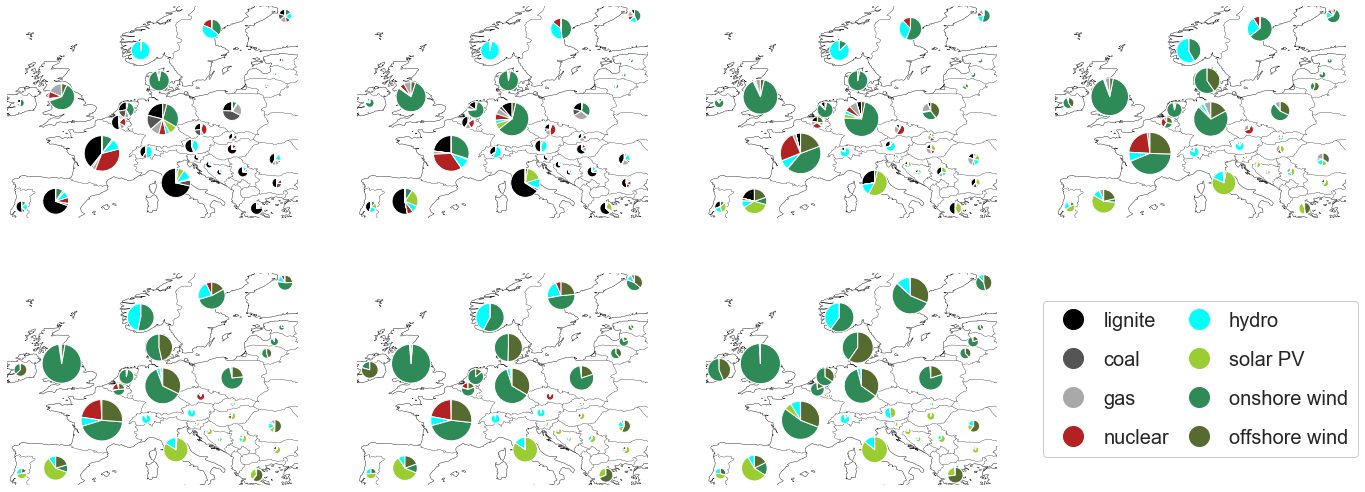

In [12]:
fig, axes = plt.subplots(2,4,subplot_kw={"projection":ccrs.PlateCarree()})
n_rows = 2
n_cols = 4
size = 6
fig.set_size_inches(24,9)
line_color="m"
n.buses.loc["NO",["x","y"]] = [7.5,60]
bus_size_factor = 100

for i,year in enumerate(years):
    i_row = i // n_cols
    i_col = i % n_cols
    ax = axes[i_row,i_col]
    
    df_ = df.reorder_levels(['year','country'],axis=1)[str(year)].T
    data = df_.stack()
    n.plot(ax=ax,
           bus_sizes=data/bus_size_factor,
           bus_colors=tech_colors.to_dict(),
           line_colors=dict(Line=line_color, Link=line_color),
           line_widths=dict(Line=0,Link=0),geomap='50m')

    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

techs = df_.columns
handles = []
labels = []
for t in techs:
    handles.append(plt.Line2D([0], [0], color=tech_colors[t], marker='o', markersize=20, linewidth=0))
    labels.append(t)

ax = axes[1,3]
first_legend = ax.legend(handles, labels,fontsize=fs,
           loc="center", #bbox_to_anchor=(-0.1, 1.1),
           framealpha=1,borderpad=0.5,labelspacing=1,
           handletextpad=0.5, columnspacing=0.5, ncol=2, title=None)

fig.savefig('../../figures/spatial_electricity_production_evolution.png', bbox_inches='tight',dpi=500)